# Import Library

In [1]:
# Import Library
import numpy as np
import pandas as pd
import tensorflow as tf
import joblib
from collections import Counter

# Data Preparation
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from imblearn.under_sampling import RandomUnderSampler
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

# Deep Learning
from gensim.models import FastText
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding,Conv1D,MaxPooling1D, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.optimizers import Adam, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping

# Evaluation Metrics
from sklearn.metrics import classification_report, confusion_matrix, f1_score, precision_score, recall_score, roc_curve, auc, make_scorer,roc_auc_score
from sklearn.model_selection import KFold, cross_validate

# Hyperparameter Tuning
from keras_tuner import RandomSearch

# Model Performance
import seaborn as sns
import matplotlib.pyplot as plt


# CNN-LSTM HP

In [ ]:
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300
max_words = 20000  

# ---------------------------------------------------------------------------------------------------------------------
file_path = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
df = pd.read_csv(file_path)

texts = df['text'].astype(str).values 
labels = df['label'].values 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts) 
X_seq = tokenizer.texts_to_sequences(texts) 
X_padding = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_train, X_test, Y_train, Y_test = train_test_split(X_padding, y, test_size=0.3, stratify=y, random_state=42)

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(X_train,Y_train)
print("Class distribution after resampling:", Counter(y_train_resampled))

# ---------------------------------------------------------------------------------------------------------------------

MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  

# https://fasttext.cc/docs/en/english-vectors.html 
fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))   

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False  
)

def build_model(hp):
    model = Sequential()
    model.add(embedding_layer)
    # The kernel size determines the number of words processed in each convolution operation 
    # for example, kernel size=3 means processing 3 words at a time
    model.add(Conv1D(filters=hp.Int("conv_filters", min_value=32, max_value=128, step=32),
                     kernel_size=hp.Int("kernel_size", min_value=3, max_value=5, step=1),
                     activation='relu',
                     padding='same'))
    # Apply 1D max pooling to downsample the feature maps
    model.add(MaxPooling1D(pool_size=hp.Int("pool_size", min_value=2, max_value=4, step=1)))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_1", min_value=64, max_value=256, step=64),return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_1", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_2", min_value=32, max_value=128, step=32),return_sequences=True)))
    model.add(Dropout(hp.Float("dropout_2", min_value=0.2, max_value=0.4, step=0.1)))

    model.add(Bidirectional(LSTM(units=hp.Int("LSTM_layer_3", min_value=16, max_value=64, step=16),return_sequences=False)))
    model.add(Dropout(hp.Float("dropout_3", min_value=0.2, max_value=0.4, step=0.1)))
    
    model.add(Dense(units=hp.Int("dense_units", min_value=16, max_value=64, step=16), 
                    activation=hp.Choice("activation", ["relu", "tanh","sigmoid"]),  
                    kernel_regularizer=tf.keras.regularizers.l2(hp.Float("l2_reg", min_value=0.001, max_value=0.1, step=0.01))))

    model.add(Dense(1, activation="sigmoid"))

    optimizer_choice = hp.Choice('optimizer', ['adam', 'sgd', 'adagrad'])
    learning_rate = hp.Choice("learning_rate", [0.0001, 0.003, 0.01, 0.3])

    if optimizer_choice == 'sgd':
        optimizer = SGD(learning_rate=learning_rate, momentum=0.9)
    elif optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    elif optimizer_choice == 'adagrad':
        optimizer = Adagrad(learning_rate=learning_rate)

    model.compile(
        optimizer = optimizer,loss="binary_crossentropy",metrics=["accuracy"]
    )
    return model

tuner = RandomSearch(build_model,
                    objective='val_accuracy',
                    max_trials=10,
                    executions_per_trial=1,
                    directory='my_dir_CNN-LSTM_Hate',
                    project_name='hyperparam_tuning_CNN-LSTM_1_FastText')

early_stopping = EarlyStopping(monitor="val_loss", patience=3, restore_best_weights=True)

tuner.search(x_train_resampled,y_train_resampled,
             epochs=10,
             batch_size=32,
             validation_data=(X_test,Y_test), 
             callbacks=[early_stopping])

best_model = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f"""Best Hyperparameter:
        CNN  conv_filters: {best_model.get('conv_filters')}
        CNN  kernel_size: {best_model.get('kernel_size')}
        CNN  pool_size: {best_model.get('pool_size')}
        Bi-LSTM  Layer 1: {best_model.get('LSTM_layer_1')}
        Bi-LSTM  Layer 2: {best_model.get('LSTM_layer_2')}
        Bi-LSTM  Layer 3: {best_model.get('LSTM_layer_3')}
        Dropout 1: {best_model.get('dropout_1')}
        Dropout 2: {best_model.get('dropout_2')}
        Dropout 3: {best_model.get('dropout_3')}
        Dense : {best_model.get('dense_units')}
        Activation : {best_model.get('activation')}
        Learning Rate : {best_model.get('learning_rate')}
        Optimizer Choice: {best_model.get('optimizer')}
        """)

model = build_model(best_model)
history = model.fit(x_train_resampled, y_train_resampled, 
                    epochs=10, 
                    batch_size=32, 
                    validation_data=(X_test, Y_test))

# Save Model ---------------------------------------------------------------------------------------------------------------------

joblib.dump(tuner, "1_CNN-LSTM_HPTuner_FastText.pkl")
model.save("1_CNN-LSTM_HP_Model.h5") 
joblib.dump(history.history, "1_CNN-LSTM_HP_History.pkl")
print("Saved successfully!")


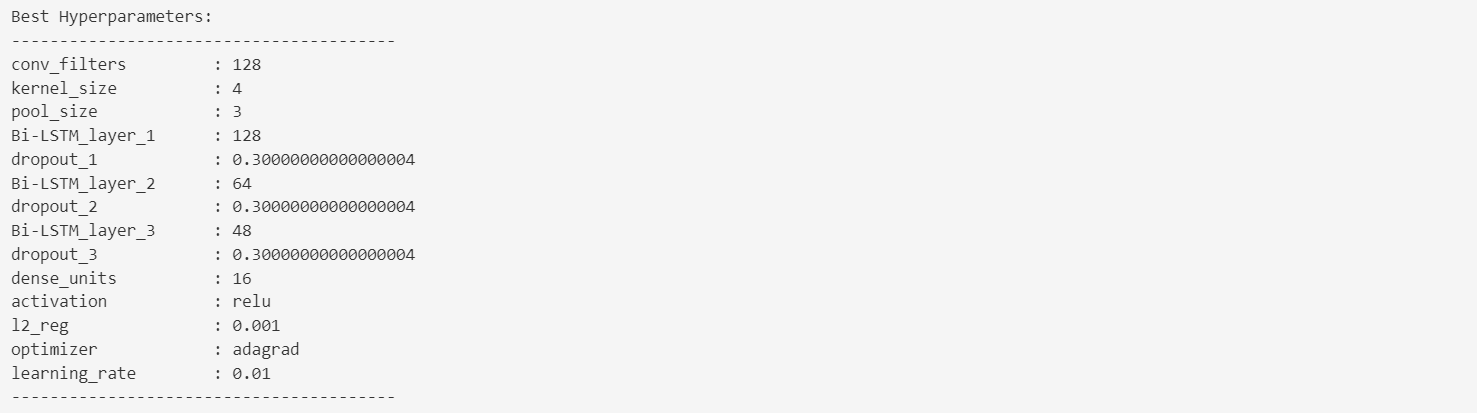

### Evaluation

In [ ]:
# Evaluate Model ---------------------------------------------------------------------------------------------------------------------\\\

train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)

y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

1129/1129 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - accuracy: 0.8233 - loss: 0.3422
770/770 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step - accuracy: 0.7863 - loss: 0.4836
770/770 ━━━━━━━━━━━━━━━━━━━━ 12s 15ms/step

📌 Train Accuracy: 0.8129
📌 Test Accuracy: 0.7887

📌 Weighted F1 Score: 0.7932
📌 Micro F1 Score: 0.7887
📌 Macro F1 Score: 0.7665

📌 Precision: 0.6368
📌 Recall: 0.7635

📌Test ROC AUC: 0.8516

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.80      0.84     16880
           1       0.64      0.76      0.69      7741

    accuracy                           0.79     24621
   macro avg       0.76      0.78      0.77     24621
weighted avg       0.80      0.79      0.79     24621


📌 Confusion Matrix:
[[13509  3371]
 [ 1831  5910]]


### Learning Curve

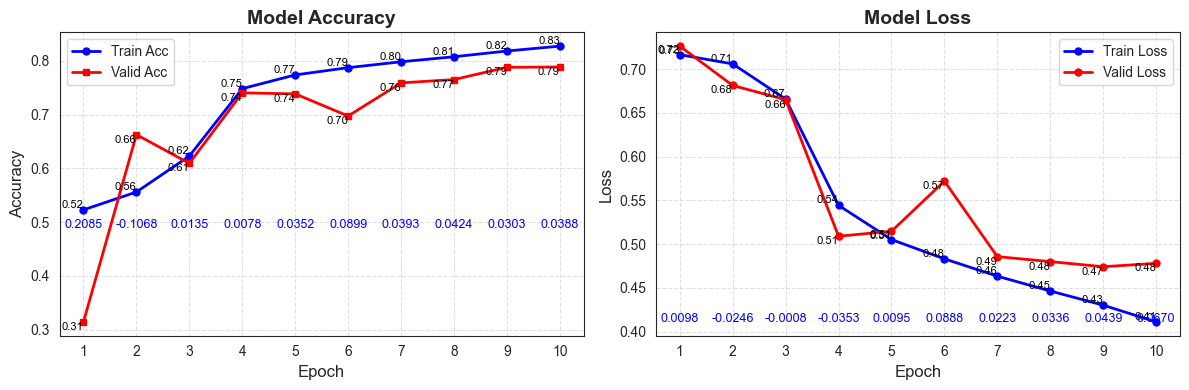

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(accuracy) + 1 )


sns.set_style("white") 
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(12, 4))

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)
axes[0].grid(True, linestyle='--', alpha=0.6)
axes[0].set_xticks(epochs) 

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)
axes[1].set_xticks(epochs)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.2f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.2f}", ha='right', va='top', fontsize=8, color='black')

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) - 0.04, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss) - 0.004, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')

plt.tight_layout()
plt.show()

###  Confusion Matrix

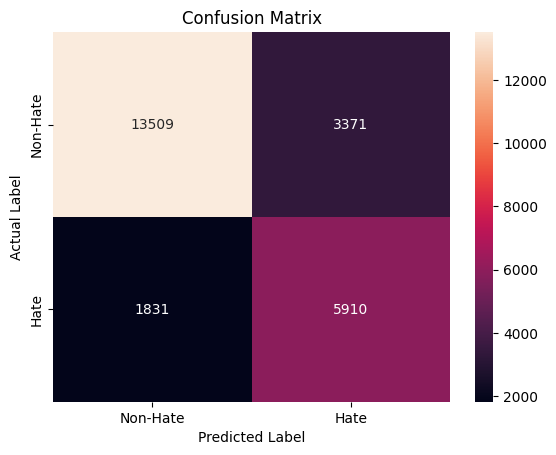

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

# annot & fmt: Display decimal values 
sns.heatmap(cm, annot=True, fmt="d",cmap=sns.color_palette("ch:start=.2,rot=-.3"), 
            xticklabels=['0: Non-Hate', '1: Hate'], 
            yticklabels=['0: Non-Hate', '1: Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()

### ROC-AUC


📌 ROC AUC: 0.8516


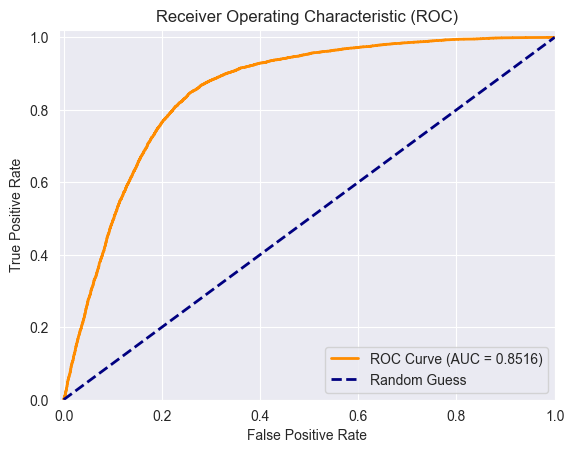

In [ ]:
fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

## precision_recall_curve


📌 Precision-Recall AUC: 0.6594


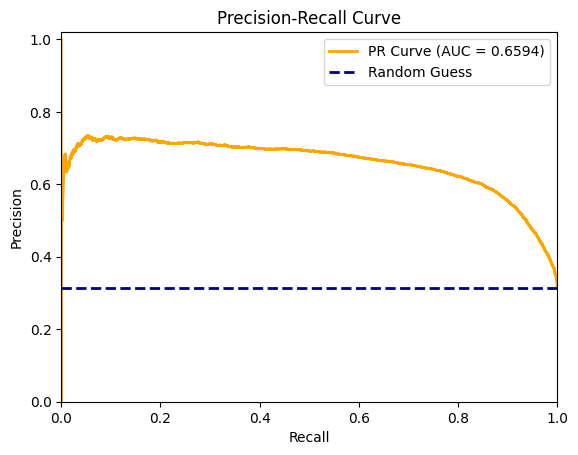

In [ ]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score


precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()


# Final Fine Tuning (model saved _1)


In [ ]:
from tensorflow.keras.callbacks import ReduceLROnPlateau
from tensorflow.keras import backend as K
from tensorflow.keras.saving import register_keras_serializable

# ---------------------------------------------------------------------------------------------------------------
MAX_SEQUENCE_LENGTH = 100  
EMBEDDING_DIM = 300
max_words = 20000  

# ---------------------------------------------------------------------------------------------------------------------

file_path = r"../Pre_Hate_Dataset/20_Hate_Final.csv"
df = pd.read_csv(file_path)

texts = df['text'].astype(str).values 
labels = df['label'].values 

label_encoder = LabelEncoder()
y = label_encoder.fit_transform(labels)

tokenizer = Tokenizer(num_words=max_words)
tokenizer.fit_on_texts(texts) 
X_seq = tokenizer.texts_to_sequences(texts) 
X_padding = pad_sequences(X_seq, maxlen=MAX_SEQUENCE_LENGTH)

X_train, X_test, Y_train, Y_test = train_test_split(X_padding, y, test_size=0.3, stratify=y, random_state=42)

# Undersampling
undersampler = RandomUnderSampler(random_state=42)
x_train_resampled, y_train_resampled = undersampler.fit_resample(X_train,Y_train)
print("Class distribution after resampling:", Counter(y_train_resampled))

# ------------------------------------------------------------------------------------------------------------------------

MAX_VOCAB_SIZE = len(tokenizer.word_index) + 1  
# https://fasttext.cc/docs/en/english-vectors.html 
fasttext_path = "crawl-300d-2M-subword.bin" 
word_vectors = FastText.load_fasttext_format(fasttext_path)

embedding_matrix = np.zeros((MAX_VOCAB_SIZE, EMBEDDING_DIM))

for word, i in tokenizer.word_index.items():
    if i < MAX_VOCAB_SIZE:
        if word in word_vectors.wv:
            embedding_matrix[i] = word_vectors.wv[word]
        else:
            embedding_matrix[i] = np.random.normal(size=(EMBEDDING_DIM,))   

embedding_layer = Embedding(
    input_dim=MAX_VOCAB_SIZE,
    output_dim=EMBEDDING_DIM,
    weights=[embedding_matrix],
    input_length=MAX_SEQUENCE_LENGTH,
    trainable=False  
)

# -----------------------------------------------------------------------------------------------------------------------------
optimizer = Adagrad(learning_rate=0.01)

def build_model():
    model = Sequential()
    model.add(embedding_layer)

    model.add(Conv1D(filters=128, kernel_size=4, activation="relu", padding="same"))
    model.add(MaxPooling1D(pool_size=3))
    
    model.add(Bidirectional(LSTM(units=128, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
    model.add(Dropout(0.3))
    model.add(Bidirectional(LSTM(units=48, return_sequences=False)))
    model.add(Dropout(0.3))

    model.add(Dense(units=16, activation='relu', kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(Dense(1, activation="sigmoid"))

    model.compile(optimizer=optimizer, loss="binary_crossentropy", metrics=['accuracy'])
    return model

reduce_lr = ReduceLROnPlateau(
    monitor='val_loss',   
    factor=0.8,           # Decrease LR (current LR * 0.5)
    patience=1,           # If val_loss does not improve for 1 epoch, reduce LR
    min_lr=0.0001,        # Setting minimum learning rate to prevent it from being too low
    verbose=1             
)

# Early stopping
early_stopping = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)

model = build_model()
history = model.fit(x_train_resampled, y_train_resampled, 
                    epochs=10, batch_size=32, 
                    validation_data=(X_test, Y_test),
                    callbacks=[early_stopping,reduce_lr])


Class distribution after resampling: Counter({0: 18063, 1: 18063})


C:\Users\Asus\AppData\Local\Temp\ipykernel_32032\2899421600.py:39: DeprecationWarning: Call to deprecated `load_fasttext_format` (use load_facebook_vectors (to use pretrained embeddings) or load_facebook_model (to continue training with the loaded full model, more RAM) instead).
  word_vectors = FastText.load_fasttext_format(fasttext_path)
c:\Users\Asus\AppData\Local\Programs\Python\Python312\Lib\site-packages\keras\src\layers\core\embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 74s 54ms/step - accuracy: 0.5287 - loss: 0.7183 - val_accuracy: 0.6372 - val_loss: 0.7074 - learning_rate: 0.0100
Epoch 2/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 58s 51ms/step - accuracy: 0.5623 - loss: 0.7071 - val_accuracy: 0.6735 - val_loss: 0.6647 - learning_rate: 0.0100
Epoch 3/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 67s 60ms/step - accuracy: 0.6556 - loss: 0.6444 - val_accuracy: 0.7133 - val_loss: 0.5479 - learning_rate: 0.0100
Epoch 4/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 102s 90ms/step - accuracy: 0.7584 - loss: 0.5312 - val_accuracy: 0.7514 - val_loss: 0.5079 - learning_rate: 0.0100
Epoch 5/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 380s 337ms/step - accuracy: 0.7805 - loss: 0.4955 - val_accuracy: 0.7427 - val_loss: 0.5049 - learning_rate: 0.0100
Epoch 6/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 85s 76ms/step - accuracy: 0.7945 - loss: 0.4732 - val_accuracy: 0.7691 - val_loss: 0.4823 - learning_rate: 0.0100
Epoch 7/10
1129/1129 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accu

In [13]:
model.save("CNN_FineTune_1_Model.keras") 
joblib.dump(history.history, "CNN_FineTune_1_History.pkl")
print("Model saved successfully!")

Model saved successfully!


## Evaluate

In [3]:
# Evaluate model
train_loss, train_accuracy = model.evaluate(x_train_resampled, y_train_resampled, verbose=1)
test_loss, test_accuracy = model.evaluate(X_test, Y_test, verbose=1)
y_pred_prob = model.predict(X_test)
y_pred = (y_pred_prob > 0.5).astype(int)

print(f"\n📌 Train Accuracy: {train_accuracy:.4f}")
print(f"📌 Test Accuracy: {test_accuracy:.4f}")

f1_weighted = f1_score(Y_test, y_pred, average='weighted')
print(f"\n📌 Weighted F1 Score: {f1_weighted:.4f}")

f1_micro = f1_score(Y_test, y_pred, average='micro')
print(f"📌 Micro F1 Score: {f1_micro:.4f}")

f1_macro = f1_score(Y_test, y_pred, average='macro')
print(f"📌 Macro F1 Score: {f1_macro:.4f}")

precision = precision_score(Y_test, y_pred, average='binary') 
print(f"\n📌 Precision: {precision:.4f}")

recall = recall_score(Y_test, y_pred, average='binary')
print(f"📌 Recall: {recall:.4f}")

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)
print(f"\n📌Test ROC AUC: {roc_auc:.4f}")

print("\n📌 Classification Report:")
print(classification_report(Y_test, y_pred))

print("\n📌 Confusion Matrix:")
print(confusion_matrix(Y_test, y_pred))

1129/1129 ━━━━━━━━━━━━━━━━━━━━ 36s 32ms/step - accuracy: 0.7794 - loss: 0.4267
770/770 ━━━━━━━━━━━━━━━━━━━━ 24s 31ms/step - accuracy: 0.7667 - loss: 0.4878
770/770 ━━━━━━━━━━━━━━━━━━━━ 21s 27ms/step

📌 Train Accuracy: 0.8057
📌 Test Accuracy: 0.7691

📌 Weighted F1 Score: 0.7766
📌 Micro F1 Score: 0.7691
📌 Macro F1 Score: 0.7537

📌 Precision: 0.5959
📌 Recall: 0.8255

📌Test ROC AUC: 0.8414

📌 Classification Report:
              precision    recall  f1-score   support

           0       0.90      0.74      0.82     16880
           1       0.60      0.83      0.69      7741

    accuracy                           0.77     24621
   macro avg       0.75      0.78      0.75     24621
weighted avg       0.81      0.77      0.78     24621


📌 Confusion Matrix:
[[12547  4333]
 [ 1351  6390]]


##  Confusion Matrix

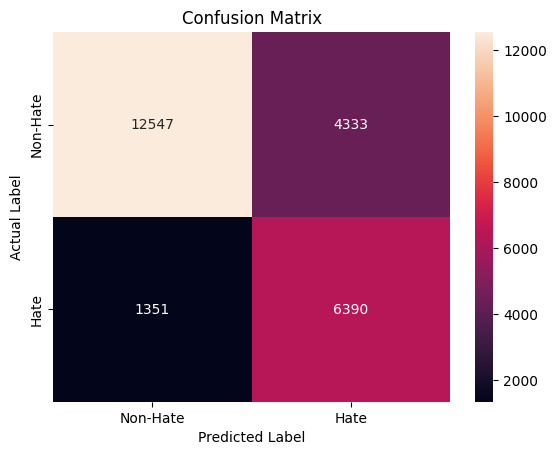

In [4]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(Y_test, y_pred)

# annot & fmt: Display decimal values 
sns.heatmap(cm, annot=True, fmt="d", 
            xticklabels=['Non-Hate', 'Hate'], 
            yticklabels=['Non-Hate', 'Hate'])


plt.xlabel("Predicted Label") 
plt.ylabel("Actual Label")  
plt.title("Confusion Matrix") 
plt.show()



## Learning Curve

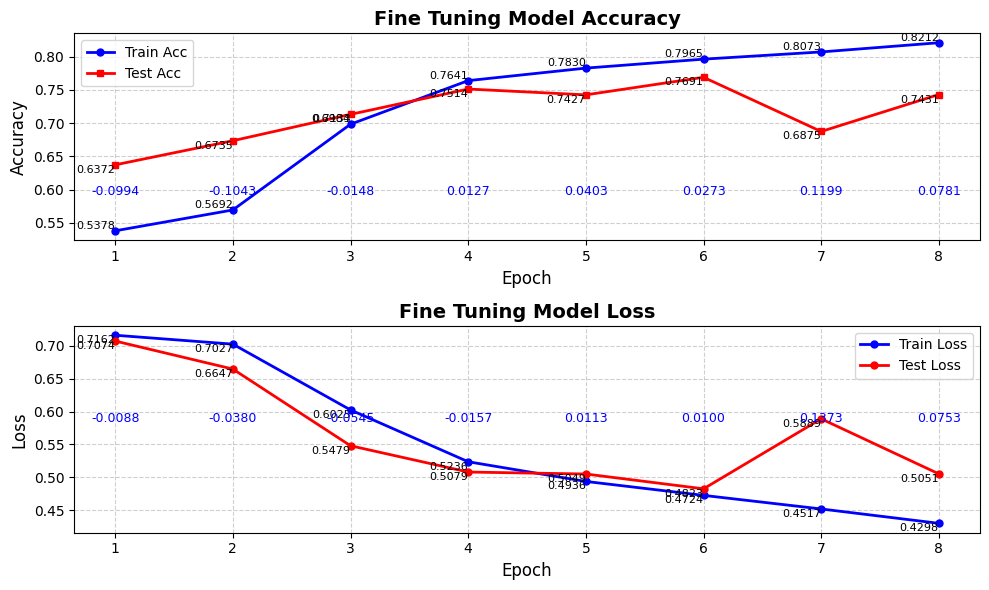

In [ ]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6)) 

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Test Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Fine Tuning Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Test Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Fine Tuning Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) +0.05, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss)+0.15, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    

plt.tight_layout()
plt.show()



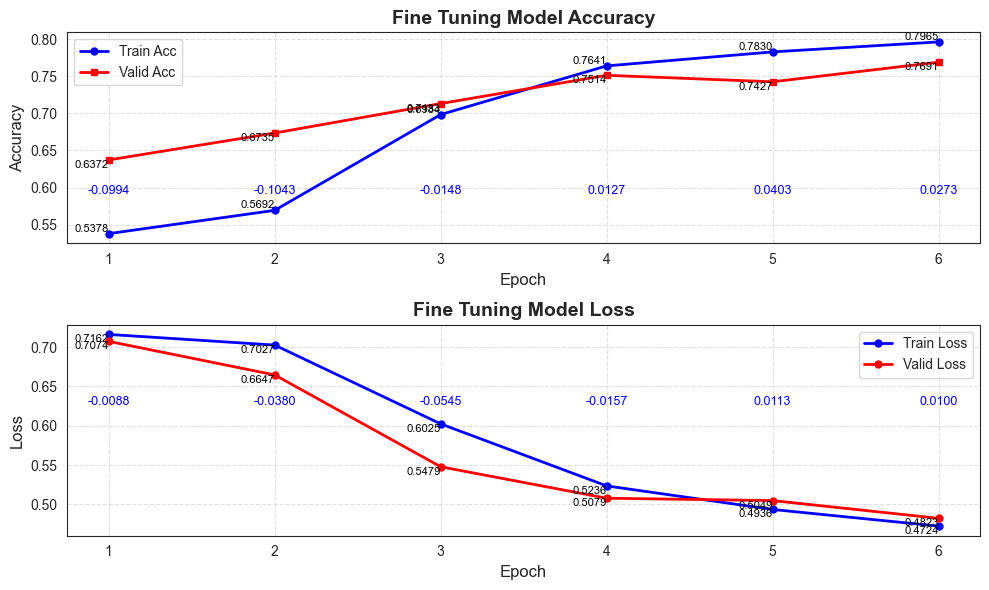

In [ ]:
accuracy = history.history['accuracy'][:6]
val_acc = history.history['val_accuracy'][:6]
loss = history.history['loss'][:6]
val_loss = history.history['val_loss'][:6]

epochs = range(1, len(accuracy) + 1)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 6))  

# Plotting the Accuracy Curve
axes[0].plot(epochs, accuracy, 'bo-', label='Train Acc', linewidth=2, markersize=5)  
axes[0].plot(epochs, val_acc, 'rs-', label='Valid Acc', linewidth=2, markersize=5)  
axes[0].set_xlabel('Epoch', fontsize=12)
axes[0].set_ylabel('Accuracy', fontsize=12)
axes[0].set_title('Fine Tuning Model Accuracy', fontsize=14, fontweight='bold')
axes[0].legend(loc='upper left', fontsize=10)

# backgroud column grid
axes[0].grid(True, linestyle='--', alpha=0.6)

for i in range(len(accuracy)):
    axes[0].text(epochs[i], accuracy[i], f"{accuracy[i]:.4f}", ha='right', va='bottom', fontsize=8, color='black')
    axes[0].text(epochs[i], val_acc[i], f"{val_acc[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

# Plotting the Loss Curve
axes[1].plot(epochs, loss, 'bo-', label='Train Loss', linewidth=2, markersize=5)  
axes[1].plot(epochs, val_loss, 'ro-', label='Valid Loss', linewidth=2, markersize=5)  
axes[1].set_xlabel('Epoch', fontsize=12)
axes[1].set_ylabel('Loss', fontsize=12)
axes[1].set_title('Fine Tuning Model Loss', fontsize=14, fontweight='bold')
axes[1].legend(loc='upper right', fontsize=10)
axes[1].grid(True, linestyle='--', alpha=0.6)

for i in range(len(loss)):
    axes[1].text(epochs[i], loss[i], f"{loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')
    axes[1].text(epochs[i], val_loss[i], f"{val_loss[i]:.4f}", ha='right', va='top', fontsize=8, color='black')

axes[0].set_xticks(range(1, len(epochs) + 1, 1)) 
axes[1].set_xticks(range(1, len(epochs) + 1, 1))  

acc_diff = [round(accuracy[i] - val_acc[i], 4) for i in range(len(accuracy))]
loss_diff = [round(val_loss[i] - loss[i] , 4) for i in range(len(loss))]

# Display the difference between Train and Test
for i in range(len(epochs)):
    axes[0].text(epochs[i], min(accuracy) +0.05, f"{acc_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
    axes[1].text(epochs[i], min(loss)+0.15, f"{loss_diff[i]:.4f}", 
                 ha='center', va='bottom', fontsize=9, color='blue')
    
plt.tight_layout()
plt.show()

## ROC-AUC


📌 ROC AUC: 0.8414


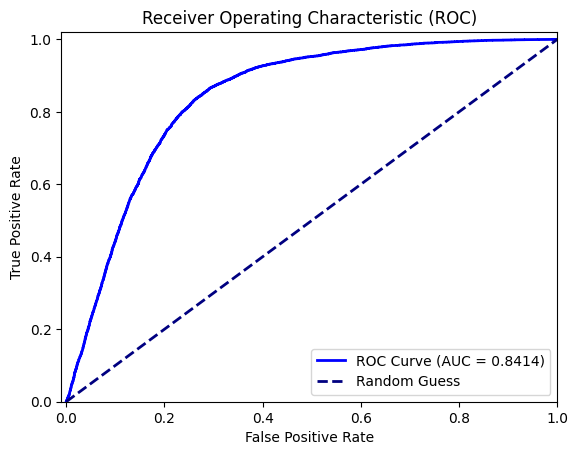

In [11]:
import matplotlib.pyplot as plt

fpr, tpr, thresholds = roc_curve(Y_test, y_pred_prob)
roc_auc = auc(fpr, tpr)

print(f"\n📌 ROC AUC: {roc_auc:.4f}")

plt.figure()

plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC Curve (AUC = {roc_auc:.4f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--',label='Random Guess')

plt.xlim([-0.01, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')

plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


## precision_recall_curve


📌 Precision-Recall AUC: 0.6306


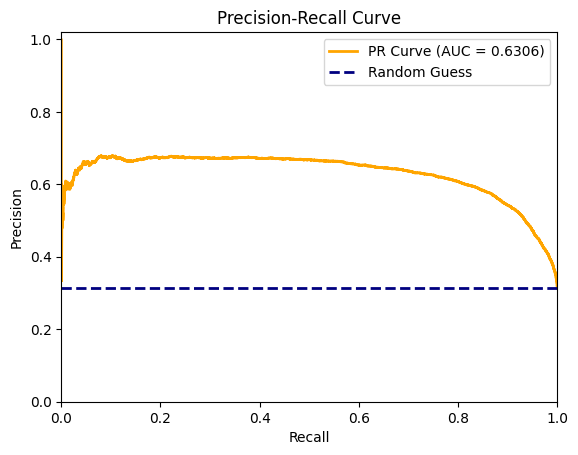

In [12]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

precision, recall, _ = precision_recall_curve(Y_test, y_pred_prob)
pr_auc = average_precision_score(Y_test, y_pred_prob)

print(f"\n📌 Precision-Recall AUC: {pr_auc:.4f}")

plt.figure()
plt.plot(recall, precision, color='orange', lw=2, label=f'PR Curve (AUC = {pr_auc:.4f})')

baseline = sum(Y_test) / len(Y_test)  
plt.plot([0, 1], [baseline, baseline], color='navy', lw=2, linestyle='--', label='Random Guess')

plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.02])

plt.xlabel('Recall')
plt.ylabel('Precision')

plt.title('Precision-Recall Curve')
plt.legend(loc="upper right")
plt.show()
